# Hedged vs Unhedged IC Comparison

Compares ICs for Baseline, Ridge, PCR, and PLS using both hedged and unhedged realized returns.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [2]:
def resolve_data_dir():
    candidates = [Path('data'), Path('../data')]
    for c in candidates:
        if (c / 'raw' / 'adr_info.csv').exists():
            return c
    raise FileNotFoundError('Could not resolve data directory')

DATA_DIR = resolve_data_dir()
PROJECT_ROOT = DATA_DIR.parent

ENTRY_TIMES = ['13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
EXCLUDED_COUNTRIES = {'AUSTRALIA', 'JAPAN'}
adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '', regex=False)
ANALYSIS_TICKERS = sorted(adr_info.loc[~adr_info['country'].isin(EXCLUDED_COUNTRIES), 'ticker'].tolist())

SIGNAL_DIRS = {
    'Baseline': PROJECT_ROOT / 'data/processed/futures_only_signal',
    'Ridge': PROJECT_ROOT / 'data/processed/index_russell_ridge_long_signal',
    'PCR': PROJECT_ROOT / 'data/processed/index_russell_pcr_signal',
    'PLS': PROJECT_ROOT / 'data/processed/index_russell_pls_signal',
}

ADR_CLOSE_FILE = DATA_DIR / 'raw' / 'adrs' / 'adr_PX_LAST_adjust_none.csv'
ETF_CLOSE_FILE = DATA_DIR / 'raw' / 'etfs' / 'market' / 'market_etf_PX_LAST_adjust_none.csv'
HEDGE_RATIO_FILE = DATA_DIR / 'processed' / 'market_etf_hedge_ratios.csv'

print('DATA_DIR:', DATA_DIR)
print('Analysis tickers:', len(ANALYSIS_TICKERS))
for k, v in SIGNAL_DIRS.items():
    print(f'{k}: {v}')


DATA_DIR: ../data
Analysis tickers: 45
Baseline: ../data/processed/futures_only_signal
Ridge: ../data/processed/index_russell_ridge_long_signal
PCR: ../data/processed/index_russell_pcr_signal
PLS: ../data/processed/index_russell_pls_signal


In [3]:
def load_nbbo_mid(path, col_name):
    df = pd.read_parquet(path, columns=['nbbo_bid', 'nbbo_ask'])
    out = pd.DataFrame(index=df.index)
    out[col_name] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    out['date'] = out.index.tz_localize(None).normalize()
    return out

def extract_prices_at_times(mid_df, times, value_col):
    all_dates = sorted(mid_df['date'].unique())
    res = pd.DataFrame(index=pd.DatetimeIndex(all_dates))
    for t in times:
        s = mid_df.between_time(t, t)[value_col]
        if len(s) == 0:
            res[t] = np.nan
            continue
        idx = s.index.tz_localize(None).normalize()
        ser = pd.Series(s.values, index=idx).groupby(level=0).first()
        res[t] = ser.reindex(res.index)
    return res

def load_signal_at_times(signal_dir, tickers, entry_times):
    signals = {}
    for ticker in tqdm(tickers, desc=f'Load signals {signal_dir.name}'):
        path = signal_dir / f'ticker={ticker}' / 'data.parquet'
        if not path.exists():
            continue
        df = pd.read_parquet(path)
        for entry_time in entry_times:
            h, m = map(int, entry_time.split(':'))
            mask = (df.index.hour == h) & (df.index.minute == m)
            sig_at_time = df.loc[mask, 'signal']
            if len(sig_at_time) == 0:
                continue
            idx = sig_at_time.index.tz_localize(None).normalize()
            ser = pd.Series(sig_at_time.values, index=idx).groupby(level=0).first()
            signals[(ticker, entry_time)] = ser
    return signals

def compute_ic(signals, returns_map, entry_times, tickers, min_obs=30, min_cs_names=8):
    pooled_rows = []
    cs_rows = []
    for entry_time in entry_times:
        pooled_sig = []
        pooled_ret = []
        by_date = {}
        for ticker in tickers:
            key = (ticker, entry_time)
            if key not in signals or key not in returns_map:
                continue
            sig = signals[key]
            ret = returns_map[key]
            common = sig.index.intersection(ret.index)
            if len(common) == 0:
                continue
            s = sig.loc[common].astype(float)
            r = ret.loc[common].astype(float)
            m = s.notna() & r.notna()
            s = s[m]
            r = r[m]
            if len(s) == 0:
                continue
            pooled_sig.extend(s.values.tolist())
            pooled_ret.extend(r.values.tolist())
            for d, sv, rv in zip(s.index, s.values, r.values):
                by_date.setdefault(d, []).append((sv, rv))

        pooled_ic = np.nan
        if len(pooled_sig) >= min_obs:
            pooled_ic = pd.Series(pooled_sig).corr(pd.Series(pooled_ret))
        pooled_rows.append({'Entry Time': entry_time, 'IC': pooled_ic, 'N obs': len(pooled_sig)})

        daily_cs = []
        for d, vals in by_date.items():
            if len(vals) < min_cs_names:
                continue
            svals = pd.Series([v[0] for v in vals])
            rvals = pd.Series([v[1] for v in vals])
            c = svals.corr(rvals)
            if pd.notna(c):
                daily_cs.append(c)
        cs_ic = float(np.mean(daily_cs)) if daily_cs else np.nan
        cs_rows.append({'Entry Time': entry_time, 'IC': cs_ic, 'N days': len(daily_cs)})

    return pd.DataFrame(pooled_rows), pd.DataFrame(cs_rows)


In [4]:
adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '', regex=False)
ticker_to_etf = dict(zip(adr_info['ticker'], adr_info['market_etf_hedge']))

tickers = sorted([t for t in ANALYSIS_TICKERS if t in set(adr_info['ticker'])])
hedge_ratios = pd.read_csv(HEDGE_RATIO_FILE, index_col=0, parse_dates=True)
close_df = pd.read_csv(ADR_CLOSE_FILE, index_col=0, parse_dates=True)
etf_close_df = pd.read_csv(ETF_CLOSE_FILE, index_col=0, parse_dates=True)

len(tickers), tickers[:5]

(45, ['AEG', 'ARGX', 'ASML', 'AZN', 'BBVA'])

In [5]:
adr_prices = {}
for ticker in tqdm(tickers, desc='ADR NBBO'):
    path = DATA_DIR / 'raw' / 'adrs' / 'bbo-1m' / 'nbbo' / f'ticker={ticker}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path, 'mid')
    adr_prices[ticker] = extract_prices_at_times(mid, ENTRY_TIMES, 'mid')

etf_prices = {}
for etf in sorted(set(ticker_to_etf[t] for t in tickers if t in ticker_to_etf)):
    path = DATA_DIR / 'raw' / 'etfs' / 'market' / 'bbo-1m' / 'nbbo' / f'ticker={etf}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path, 'etf_mid')
    etf_prices[etf] = extract_prices_at_times(mid, ENTRY_TIMES, 'etf_mid')

hedged_returns = {}
unhedged_returns = {}

for ticker in tickers:
    if ticker not in adr_prices:
        continue
    etf = ticker_to_etf.get(ticker)
    if etf not in etf_prices:
        continue
    if ticker not in hedge_ratios.columns or ticker not in close_df.columns or etf not in etf_close_df.columns:
        continue

    adr_px = adr_prices[ticker]
    etf_px = etf_prices[etf]
    adr_close = close_df[ticker].dropna()
    etf_close = etf_close_df[etf].dropna()
    hr = hedge_ratios[ticker].dropna()

    common_dates = adr_px.index.intersection(etf_px.index).intersection(adr_close.index).intersection(etf_close.index)
    if len(common_dates) == 0:
        continue

    for entry_time in ENTRY_TIMES:
        adr_entry = adr_px.loc[common_dates, entry_time]
        etf_entry = etf_px.loc[common_dates, entry_time]
        valid = adr_entry.notna() & etf_entry.notna()
        d = common_dates[valid.values]
        if len(d) == 0:
            continue

        ae = adr_entry.loc[d].astype(float)
        ee = etf_entry.loc[d].astype(float)
        ac = adr_close.reindex(d).astype(float)
        ec = etf_close.reindex(d).astype(float)
        hr_aligned = hr.reindex(d).astype(float)

        adr_ret = ((ac - ae) / ae).replace([np.inf, -np.inf], np.nan).dropna()
        etf_ret = ((ec - ee) / ee).replace([np.inf, -np.inf], np.nan).dropna()

        common2 = adr_ret.index.intersection(etf_ret.index).intersection(hr_aligned.dropna().index)
        if len(common2) == 0:
            continue

        adr_ret2 = adr_ret.reindex(common2).dropna()
        etf_ret2 = etf_ret.reindex(common2).dropna()
        hr2 = hr_aligned.reindex(common2).dropna()
        common3 = adr_ret2.index.intersection(etf_ret2.index).intersection(hr2.index)
        if len(common3) == 0:
            continue

        adr_ret3 = adr_ret2.reindex(common3)
        etf_ret3 = etf_ret2.reindex(common3)
        hr3 = hr2.reindex(common3)

        hedged = (adr_ret3 - hr3 * etf_ret3).replace([np.inf, -np.inf], np.nan).dropna()
        unhedged = adr_ret3.reindex(hedged.index).dropna()

        if len(hedged) == 0 or len(unhedged) == 0:
            continue

        hedged_returns[(ticker, entry_time)] = pd.Series(hedged.values, index=hedged.index, name=ticker)
        unhedged_returns[(ticker, entry_time)] = pd.Series(unhedged.values, index=unhedged.index, name=ticker)

print('Hedged pairs:', len(hedged_returns))
print('Unhedged pairs:', len(unhedged_returns))

ADR NBBO:   0%|          | 0/45 [00:00<?, ?it/s]

Hedged pairs: 270
Unhedged pairs: 270


In [6]:
signals_by_model = {}
for model_name, signal_dir in SIGNAL_DIRS.items():
    signals_by_model[model_name] = load_signal_at_times(signal_dir, tickers, ENTRY_TIMES)
    print(model_name, 'signal pairs:', len(signals_by_model[model_name]))

Load signals futures_only_signal:   0%|          | 0/45 [00:00<?, ?it/s]

Baseline signal pairs: 270


Load signals index_russell_ridge_long_signal:   0%|          | 0/45 [00:00<?, ?it/s]

Ridge signal pairs: 234


Load signals index_russell_pcr_signal:   0%|          | 0/45 [00:00<?, ?it/s]

PCR signal pairs: 234


Load signals index_russell_pls_signal:   0%|          | 0/45 [00:00<?, ?it/s]

PLS signal pairs: 234


In [7]:
rows = []
for model_name, signals in signals_by_model.items():
    pooled_h, cs_h = compute_ic(signals, hedged_returns, ENTRY_TIMES, tickers)
    pooled_u, cs_u = compute_ic(signals, unhedged_returns, ENTRY_TIMES, tickers)

    ph = pooled_h[['Entry Time', 'IC']].rename(columns={'IC': 'Hedged Pooled IC'})
    pu = pooled_u[['Entry Time', 'IC']].rename(columns={'IC': 'Unhedged Pooled IC'})
    ch = cs_h[['Entry Time', 'IC']].rename(columns={'IC': 'Hedged CS IC'})
    cu = cs_u[['Entry Time', 'IC']].rename(columns={'IC': 'Unhedged CS IC'})

    m = ph.merge(pu, on='Entry Time').merge(ch, on='Entry Time').merge(cu, on='Entry Time')
    m['Model'] = model_name
    m['Pooled Delta (Unhedged-Hedged)'] = m['Unhedged Pooled IC'] - m['Hedged Pooled IC']
    m['CS Delta (Unhedged-Hedged)'] = m['Unhedged CS IC'] - m['Hedged CS IC']
    rows.append(m)

comparison = pd.concat(rows, ignore_index=True)
comparison.head()

,Entry Time,Hedged Pooled IC,Unhedged Pooled IC,Hedged CS IC,Unhedged CS IC,Model,Pooled Delta (Unhedged-Hedged),CS Delta (Unhedged-Hedged)
0,13:00,0.015011,0.014901,0.028805,0.028114,Baseline,-0.000110,-0.000691
1,13:30,0.016408,0.016587,0.027859,0.028186,Baseline,0.000179,0.000327
2,14:00,0.012372,0.012885,0.030751,0.030329,Baseline,0.000512,-0.000422
3,14:30,0.010370,0.010422,0.030881,0.030259,Baseline,0.000052,-0.000622
4,15:00,0.008071,0.008278,0.027855,0.027586,Baseline,0.000207,-0.000269


In [8]:
summary = comparison.groupby('Model', as_index=False).agg({
    'Hedged Pooled IC': 'mean',
    'Unhedged Pooled IC': 'mean',
    'Pooled Delta (Unhedged-Hedged)': 'mean',
    'Hedged CS IC': 'mean',
    'Unhedged CS IC': 'mean',
    'CS Delta (Unhedged-Hedged)': 'mean',
})
summary.sort_values('Hedged CS IC', ascending=False)

,Model,Hedged Pooled IC,Unhedged Pooled IC,Pooled Delta (Unhedged-Hedged),Hedged CS IC,Unhedged CS IC,CS Delta (Unhedged-Hedged)
1,PCR,0.039816,0.039884,0.000068,0.051688,0.050901,-0.000786
3,Ridge,0.028917,0.029069,0.000152,0.040711,0.040129,-0.000582
2,PLS,0.026270,0.026283,0.000013,0.036119,0.035484,-0.000635
0,Baseline,0.011653,0.011835,0.000183,0.028369,0.028183,-0.000186


In [9]:
pooled_pivot = comparison.pivot(index='Entry Time', columns='Model', values='Hedged Pooled IC')
pooled_unhedged_pivot = comparison.pivot(index='Entry Time', columns='Model', values='Unhedged Pooled IC')
cs_pivot = comparison.pivot(index='Entry Time', columns='Model', values='Hedged CS IC')
cs_unhedged_pivot = comparison.pivot(index='Entry Time', columns='Model', values='Unhedged CS IC')

print('Hedged pooled IC:')
display(pooled_pivot)
print('Unhedged pooled IC:')
display(pooled_unhedged_pivot)
print('Hedged cross-sectional IC:')
display(cs_pivot)
print('Unhedged cross-sectional IC:')
display(cs_unhedged_pivot)

Hedged pooled IC:


Model,Baseline,PCR,PLS,Ridge
Entry Time,,,,
13:00,0.015011,0.040727,0.025418,0.019765
13:30,0.016408,0.039824,0.020942,0.022677
14:00,0.012372,0.041062,0.028394,0.033461
14:30,0.010370,0.042344,0.031021,0.031821
15:00,0.008071,0.042619,0.030966,0.035870
15:30,0.007684,0.032321,0.020881,0.029909


Unhedged pooled IC:


Model,Baseline,PCR,PLS,Ridge
Entry Time,,,,
13:00,0.014901,0.040399,0.025037,0.019779
13:30,0.016587,0.039493,0.020557,0.022628
14:00,0.012885,0.041213,0.028452,0.033495
14:30,0.010422,0.042976,0.031536,0.032335
15:00,0.008278,0.042753,0.031102,0.036115
15:30,0.007939,0.032470,0.021017,0.030062


Hedged cross-sectional IC:


Model,Baseline,PCR,PLS,Ridge
Entry Time,,,,
13:00,0.028805,0.035792,0.016427,0.015199
13:30,0.027859,0.046457,0.029981,0.025944
14:00,0.030751,0.061814,0.045007,0.049103
14:30,0.030881,0.060181,0.048127,0.051235
15:00,0.027855,0.058494,0.043205,0.054998
15:30,0.024066,0.047386,0.033966,0.047785


Unhedged cross-sectional IC:


Model,Baseline,PCR,PLS,Ridge
Entry Time,,,,
13:00,0.028114,0.034839,0.015461,0.014803
13:30,0.028186,0.045168,0.029292,0.025540
14:00,0.030329,0.060258,0.043933,0.048313
14:30,0.030259,0.059231,0.047239,0.049730
15:00,0.027586,0.058287,0.042682,0.055026
15:30,0.024624,0.047626,0.034296,0.047361


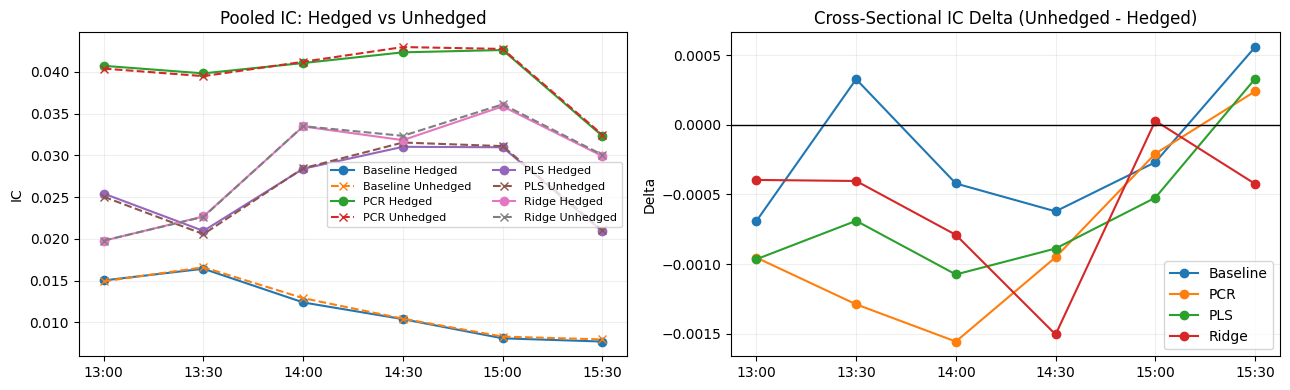

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

for model in summary['Model']:
    sub = comparison[comparison['Model'] == model].sort_values('Entry Time')
    axes[0].plot(sub['Entry Time'], sub['Hedged Pooled IC'], marker='o', label=f'{model} Hedged')
    axes[0].plot(sub['Entry Time'], sub['Unhedged Pooled IC'], marker='x', linestyle='--', label=f'{model} Unhedged')

axes[0].set_title('Pooled IC: Hedged vs Unhedged')
axes[0].set_ylabel('IC')
axes[0].grid(alpha=0.2)
axes[0].legend(ncol=2, fontsize=8)

for model in summary['Model']:
    sub = comparison[comparison['Model'] == model].sort_values('Entry Time')
    axes[1].plot(sub['Entry Time'], sub['CS Delta (Unhedged-Hedged)'], marker='o', label=model)

axes[1].axhline(0.0, color='black', linewidth=1)
axes[1].set_title('Cross-Sectional IC Delta (Unhedged - Hedged)')
axes[1].set_ylabel('Delta')
axes[1].grid(alpha=0.2)
axes[1].legend()

plt.tight_layout()

In [11]:
out_dir = PROJECT_ROOT / 'data/processed/reports/signal_ic'
out_dir.mkdir(parents=True, exist_ok=True)
comparison.to_csv(out_dir / 'hedged_vs_unhedged_ic_by_time.csv', index=False)
summary.to_csv(out_dir / 'hedged_vs_unhedged_ic_summary.csv', index=False)
print('Saved:', out_dir / 'hedged_vs_unhedged_ic_by_time.csv')
print('Saved:', out_dir / 'hedged_vs_unhedged_ic_summary.csv')

Saved: ../data/processed/reports/signal_ic/hedged_vs_unhedged_ic_by_time.csv
Saved: ../data/processed/reports/signal_ic/hedged_vs_unhedged_ic_summary.csv
